# Домашнє завдання: Прогнозування кредитного ризику

## Мета завдання
Застосувати знання з лекції для побудови моделі логістичної регресії, що прогнозує ймовірність дефолту за кредитом, іншими словами, що людина не поверне кредит. Ви пройдете весь цикл: від дослідницького аналізу до оцінки якості класифікаційної моделі.

## Опис датасету
**Credit Risk Dataset** містить інформацію про 32,000+ позичальників з такими параметрами:
- **person_age**: Вік позичальника
- **person_income**: Річний дохід
- **person_home_ownership**: Тип володіння житлом
- **person_emp_length**: Стаж роботи (в роках)
- **loan_intent**: Мета кредиту
- **loan_grade**: Кредитний рейтинг (A - кращий, F - гірший)
- **loan_amnt**: Сума кредиту
- **loan_int_rate**: Процентна ставка
- **loan_status**: Статус кредиту (0 = сплачено, 1 = дефолт) - **цільова змінна**
- **loan_percent_income**: Відношення кредиту до доходу
- **cb_person_default_on_file**: Історія дефолтів (Y/N)
- **cb_person_cred_hist_length**: Довжина кредитної історії

---

## Завдання 1: Завантаження та перший огляд даних (1 бал)

**Що потрібно зробити:**
1. Завантажте дані з файлу `credit_risk_dataset.csv`
2. Виведіть розмір датасету
3. Покажіть перші 5 рядків
4. Виведіть загальну інформацію про дані (кількість записів, типи колонок)
5. Перевірте розподіл цільової змінної (відсотк даних для кожного класу)

Дайте висновок, це задача збалансованої чи незбалансованої класифікації.


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. Завантаження даних
df = pd.read_csv('../data/credit_risk_dataset.csv', sep=None, engine='python')

# 2. Розмір датасету
df.shape

(32581, 12)

In [2]:
# 3. Перші 5 рядків
df.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
# 4. Загальна інформація
print("\nЗагальна інформація:")
display(df.info())


Загальна інформація:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


None

In [4]:
# 5. Перевірка розподілу цільової змінної
loan_status_dist = df['loan_status'].value_counts()
loan_status_percent = df['loan_status'].value_counts(normalize=True) * 100

loan_status_percent

loan_status
0    78.183604
1    21.816396
Name: proportion, dtype: float64

**Отже, ми маємо справу з незбалансованим датасетом (78% vs 22%). Тобто більшість клієнтів сплачують кредити.**


---

## Завдання 2: Дослідницький аналіз даних (EDA) (4 бали)

**Що потрібно зробити:**
1. Обчисліть відсоток пропущених значень в колонках. За наявності пропущених значень - заповніть їх медіаною для числових колонок і найбільш частим значеннмя для категоріальних.
2. Проаналізуйте розподіл числових змінних.
3. Знайдіть та обробіть викиди в колонці person_income з допомогою [Interquartile range](https://uk.wikipedia.org/wiki/%D0%9C%D1%96%D0%B6%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D0%BB%D1%8C%D0%BD%D0%B8%D0%B9_%D1%80%D0%BE%D0%B7%D0%BC%D0%B0%D1%85).
4. Проаналізуйте категоріальні змінні відносно цільової та частоту зустрічання різних значень в них.
5. Візуалізуйте взаємозв'язок ознак з цільовою змінною.


In [5]:
# 1. Обчислення відсотку пропущених значень.
print("Пропущені значення в кожній колонці:")
print(df.isnull().sum())

Пропущені значення в кожній колонці:
person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [6]:
# Заповнення пропущених значень
num_cols = df.select_dtypes(include=["Int64", "float"]).columns
for col in num_cols:
    df[col].fillna(df[col].median(), inplace= True)

cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace= True)

print("Пропущені значення після обробки:")
print(df.isna().sum())

Пропущені значення після обробки:
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


In [7]:
# 2. Аналіз розподілу числових змінних
df.select_dtypes("number").describe().applymap(lambda x: f"{x:.2f}")

C:\Users\User\AppData\Local\Temp\ipykernel_5040\390321347.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.select_dtypes("number").describe().applymap(lambda x: f"{x:.2f}")


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.00,32581.00,32581.00,32581.00,32581.00,32581.00,32581.00,32581.00
mean,27.73,66074.85,4.77,9589.37,11.01,0.22,0.17,5.80
std,6.35,61983.12,4.09,6322.09,3.08,0.41,0.11,4.06
min,20.00,4000.00,0.00,500.00,5.42,0.00,0.00,2.00
25%,23.00,38500.00,2.00,5000.00,8.49,0.00,0.09,3.00
50%,26.00,55000.00,4.00,8000.00,10.99,0.00,0.15,4.00
75%,30.00,79200.00,7.00,12200.00,13.11,0.00,0.23,8.00
max,144.00,6000000.00,123.00,35000.00,23.22,1.00,0.83,30.00


In [8]:
# 3. Boxplot для виявлення викидів
fig = px.box(df, x='person_income',
             title='Boxplot person_income')
fig.show()

**У нас є значна кількість викидів, які очквидно тягнуть за собою середнє значення змінної. Було б доцільно виключити викиди для чистішого аналізу.**

In [9]:
# Пошук та видалення викидів
Q1 = df['person_income'].quantile(0.25)
Q3 = df['person_income'].quantile(0.75)
IQR = Q3 - Q1

# Визначаємо межі для викидів
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Межі для викидів: {lower_bound:.0f} - {upper_bound:.0f}")

#Видаляємо викиди
outliers = df[(df['person_income'] < lower_bound) | (df['person_income'] > upper_bound)]
print(f"Знайдено викидів: {len(outliers)}")

df_clean = df[(df['person_income'] >= lower_bound) & (df['person_income'] <= upper_bound)]
print(f"Розмір після видалення викидів: {df_clean.shape}")

Межі для викидів: -22550 - 140250
Знайдено викидів: 1484
Розмір після видалення викидів: (31097, 12)


In [10]:
# 4. Аналіз категоріальних змінних відносно цільової.
cat_cols = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]

for col in cat_cols:
    print(f"\n{col} - частота значень:")
    print(df[col].value_counts(normalize=True).round(3)*100)


person_home_ownership - частота значень:
person_home_ownership
RENT        50.5
MORTGAGE    41.3
OWN          7.9
OTHER        0.3
Name: proportion, dtype: float64

loan_intent - частота значень:
loan_intent
EDUCATION            19.8
MEDICAL              18.6
VENTURE              17.6
PERSONAL             16.9
DEBTCONSOLIDATION    16.0
HOMEIMPROVEMENT      11.1
Name: proportion, dtype: float64

loan_grade - частота значень:
loan_grade
A    33.1
B    32.1
C    19.8
D    11.1
E     3.0
F     0.7
G     0.2
Name: proportion, dtype: float64

cb_person_default_on_file - частота значень:
cb_person_default_on_file
N    82.4
Y    17.6
Name: proportion, dtype: float64


In [11]:
for col in cat_cols:
    
    print(f"\n{col} vs loan_status:")
    print(pd.crosstab(df[col], df['loan_status'], normalize="index").round(3)*100)


person_home_ownership vs loan_status:
loan_status               0     1
person_home_ownership            
MORTGAGE               87.4  12.6
OTHER                  69.2  30.8
OWN                    92.5   7.5
RENT                   68.4  31.6

loan_intent vs loan_status:
loan_status           0     1
loan_intent                  
DEBTCONSOLIDATION  71.4  28.6
EDUCATION          82.8  17.2
HOMEIMPROVEMENT    73.9  26.1
MEDICAL            73.3  26.7
PERSONAL           80.1  19.9
VENTURE            85.2  14.8

loan_grade vs loan_status:
loan_status     0     1
loan_grade             
A            90.0  10.0
B            83.7  16.3
C            79.3  20.7
D            41.0  59.0
E            35.6  64.4
F            29.5  70.5
G             1.6  98.4

cb_person_default_on_file vs loan_status:
loan_status                   0     1
cb_person_default_on_file            
N                          81.6  18.4
Y                          62.2  37.8


In [32]:
# 5. Візуалізація взаємозв'язку з цільовою змінною.
# Залежність сплати кредиту від процентної ставки
import plotly.express as px

fig = px.box(
    df,
    x="loan_status",
    y="loan_int_rate",
    title="Розподіл процентної ставки за статусом кредиту",
    labels={"loan_int_rate": "Процентна ставка", "loan_status": "Статус кредиту"},
    color="loan_status",
    color_discrete_map={0:"#2ecc71", 1:"#e74c3c"}  # 0 = не дефолт, 1 = дефолт
)
fig.show()


**Висновок: що менша процентна ставка, то частіше кредит буде виплачено клієнтом.**

In [13]:
#Залежність від типу володіння житлом
ownership_status = df.groupby(["person_home_ownership", "loan_status"]).size().unstack()
ownership_status_pct = ownership_status.div(ownership_status.sum(axis=1), axis=0) * 100

fig = px.bar(
    ownership_status_pct.T,
    title="Статус кредиту за типом володіння житлом",
    labels={"value": "Відсоток (%)", "index": "Статус кредиту"},
    barmode="group",
    color_discrete_map={0:"#2ecc71", 1:"#e74c3c"}
)
fig.show()


**Висновок: клієнти, що орендують житло, сплачують кредити набагато рідше, ніж ті, хто є власниками особистого житла, або ніж ті, хто сплачує іпотеку.**

In [14]:
#Залежність від мети кредиту
loan_intent_type = df.groupby(["loan_intent", "loan_status"]).size().unstack()
loan_intent_type_pct = loan_intent_type.div(loan_intent_type.sum(axis=1), axis=0) * 100

fig = px.bar(
    loan_intent_type_pct.T,
    title="Статус кредиту за типом мети отримання кредиту",
    labels={"value": "Відсоток (%)", "index": "Статус кредиту"},
    barmode="group",
    color_discrete_map={0:"#2ecc71", 1:"#e74c3c"}
)
fig.show()


---

## Завдання 3: Аналіз кореляцій та Feature Engineering (3 бали)

**Що потрібно зробити:**
1. Побудуйте матрицю кореляцій для числових змінних.
2. Закодуйте категоріальні змінні.
3. Виберіть фінальний набір ознак, можна лишити всі, якщо ви вважаєте, що це - доцільно.



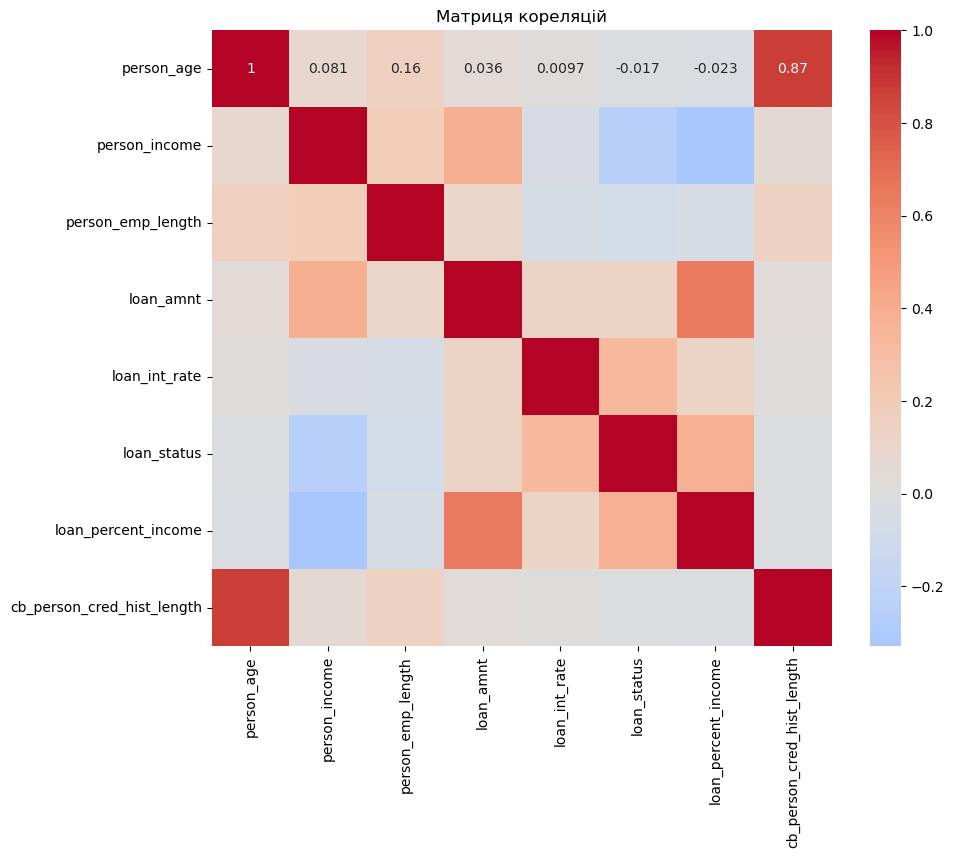

In [15]:
# 1. Матриця кореляцій для числових змінних.
num_cols = df_clean.select_dtypes(include=[np.number]).columns
correlation_matrix = df_clean[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матриця кореляцій')
plt.show()

In [16]:
# 2. One-Hot Encoding для категоріальних змінних
cat_cols = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]

df_encoded = pd.get_dummies(df_clean, columns=cat_cols,
                           drop_first=True)

In [17]:
# 3. Вибір набору ознак
y = df_encoded["loan_status"] #цільова змінна

# Категоріальні ознаки
cat_cols = ["person_home_ownership", "loan_intent", "cb_person_default_on_file"]

# Числові ознаки
num_cols = ["person_age", "person_emp_length",
            "loan_int_rate", "loan_percent_income", 
            "cb_person_cred_hist_length"]

# Фінальний набір
feature_cols = [col for col in df_encoded.columns if col != "loan_status"]
X = df_encoded[feature_cols]

print(f"Кількість ознак: {X.shape[1]}")
print(f"Розмір вибірки: {X.shape[0]}")


Кількість ознак: 22
Розмір вибірки: 31097


**loan_amnt і loan_percent_income буде доцільно лишити лише одну ознаку.**


---

## Завдання 4: Підготовка даних та навчання моделі (3 бали)

**Що потрібно зробити:**
1. Розділіть дані на X та y
2. Поділіть на навчальну та тестову вибірки
3. Застосуйте масштабування
4. Навчіть модель логістичної регресії
5. Зробіть прогнози на тренувальній та тестовій вибірках.



In [18]:
# 1. Розділення данних на х і у було проведено в попередньому завданні
# 2. Розділення даних на навчальну та тестову вибірки
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Зберігаємо пропорції класів
)

print(f"Train: {X_train.shape[0]} клієнтів")
print(f"Test: {X_test.shape[0]} клієнтів")
print(f"Кількість сплачених кредитів у train: {y_train.mean():.1%}")
print(f"Кількість сплачених кредитів у test: {y_test.mean():.1%}")

Train: 24877 клієнтів
Test: 6220 клієнтів
Кількість сплачених кредитів у train: 22.4%
Кількість сплачених кредитів у test: 22.4%


In [19]:
# 3. Масштабування
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# 4. Логістична регресія
from sklearn.linear_model import LogisticRegression

# Створюємо та навчаємо модель
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

print("Модель навчена!")

Модель навчена!


In [21]:
model

LogisticRegression(max_iter=1000, random_state=42)

In [22]:
# 5. Прогнозування на тренувальній і тестових вибірках
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print(f"\nПерші 5 прогнозів: {y_test_pred[:5]}")
print(f"Перші 5 реальних значень: {y_test.iloc[:5].values}")


Перші 5 прогнозів: [0 0 0 0 1]
Перші 5 реальних значень: [0 0 0 0 0]


In [23]:
# Прогнозуємо класи
y_pred = model.predict(X_test_scaled)

# Прогнозуємо ймовірності
y_pred_proba = model.predict_proba(X_test_scaled)

In [24]:
y_pred_proba

array([[0.96857492, 0.03142508],
       [0.9864314 , 0.0135686 ],
       [0.96520606, 0.03479394],
       ...,
       [0.461498  , 0.538502  ],
       [0.92474778, 0.07525222],
       [0.99242734, 0.00757266]])

In [25]:
(y_pred_proba[:, 1]>0.6).astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
# Приклад прогнозів для перших 5 клієнтів
sample_predictions = pd.DataFrame({
    'Реальний статус (0=не дефолт, 1=дефолт)': y_test.values[:5],
    'Прогноз': y_pred[:5],
    'Ймовірність не дефолту': y_pred_proba[:5, 0].round(3),
    'Ймовірність дефолту': y_pred_proba[:5, 1].round(3)
})
print(sample_predictions)

   Реальний статус (0=не дефолт, 1=дефолт)  Прогноз  Ймовірність не дефолту  \
0                                        0        0                   0.969   
1                                        0        0                   0.986   
2                                        0        0                   0.965   
3                                        0        0                   0.966   
4                                        0        1                   0.164   

   Ймовірність дефолту  
0                0.031  
1                0.014  
2                0.035  
3                0.034  
4                0.836  



---

## Завдання 5: Оцінка якості моделі (4 бали)

**Що потрібно зробити:**
1. Побудуйте confusion matrix.
2. Обчисліть основні метрики (accuracy, precision, recall, f1).
3. Побудуйте ROC-криву та обчисліть AUC
4. Проаналізуйте важливість ознак.
5. Зробіть висновки про якість моделі та які ознаки найбільше впливають на прогноз.


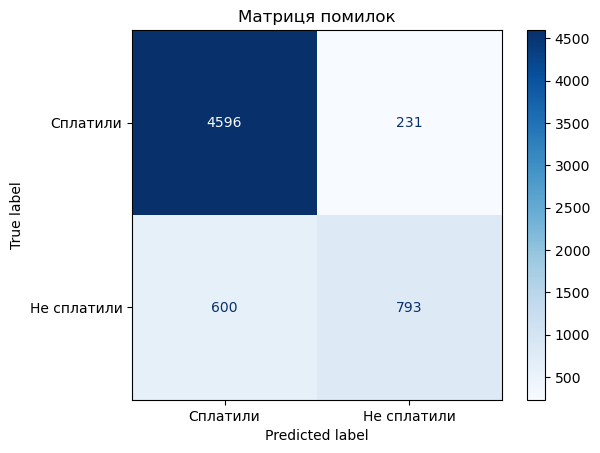

In [27]:
# 1. Confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Сплатили', 'Не сплатили'])
disp.plot(cmap='Blues')
plt.title('Матриця помилок')
plt.show()

**Модель значно більше правильно визначає статус сплати кредиту, ніж помиляється. Особливо добре було спрогнозовано сплату кредитів.**

In [28]:
# 2. Основні метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("МЕТРИКИ ЯКОСТІ МОДЕЛІ:")
print(f"Accuracy (Точність):    {accuracy:.3f}")
print(f"Precision (Влучність):  {precision:.3f}")
print(f"Recall (Повнота):       {recall:.3f}")
print(f"F1-score:               {f1:.3f}")

МЕТРИКИ ЯКОСТІ МОДЕЛІ:
Accuracy (Точність):    0.866
Precision (Влучність):  0.774
Recall (Повнота):       0.569
F1-score:               0.656


**Модель добре показує себе під час оцінки основних метрик. Результати говорять про стабільність і влучність прогнозів.**

In [29]:
# 3. ROC і AUC
from sklearn.metrics import roc_curve, roc_auc_score

# Обчислюємо ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
auc = roc_auc_score(y_test, y_pred_proba[:, 1])

# Візуалізація
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC (AUC = {auc:.3f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'),
                        name='Випадковий класифікатор'))
fig.update_layout(
    title='ROC-крива',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    height=500
)
fig.show()

**Висновок: AUC > 0.8- модель є хорошою.**

In [30]:
# 4. Ааналіз важливості ознак.
# Отримуємо коефіцієнти моделі
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0],
    'abs_coefficient': np.abs(model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

feature_importance

,feature,coefficient,abs_coefficient
5,loan_percent_income,1.320734,1.320734
17,loan_grade_D,0.810887,0.810887
3,loan_amnt,-0.548753,0.548753
18,loan_grade_E,0.476109,0.476109
8,person_home_ownership_OWN,-0.458149,0.458149
9,person_home_ownership_RENT,0.404981,0.404981
14,loan_intent_VENTURE,-0.400907,0.400907
10,loan_intent_EDUCATION,-0.327289,0.327289
20,loan_grade_G,0.309605,0.309605
19,loan_grade_F,0.268611,0.268611



---

## Завдання 6: Оптимізація порогу та бізнес-аналіз (2 бали)

**Що потрібно зробити:**
1. Проаналізуйте метрики precision, recall, F1 при різних порогах класифікації (мінімум - 5 різних порогів). Візуалізуйте як змінюються метрики якості при зміні порогу.
2. Оберіть оптимальний поріг для бізнес-задачі - можна обрати виходячи з попереднього пункту, або додати своїх роздумів і обрати інший.



In [33]:
# Аналіз різних порогів
thresholds = [0.2, 0.4, 0.5, 0.6, 0.8]
metrics_by_threshold = []

for threshold in thresholds:
    y_pred_custom = (y_pred_proba[:, 1] >= threshold).astype(int)

    metrics_by_threshold.append({
        'threshold': threshold,
        'precision': precision_score(y_test, y_pred_custom),
        'recall': recall_score(y_test, y_pred_custom),
        'f1': f1_score(y_test, y_pred_custom)
    })

metrics_df = pd.DataFrame(metrics_by_threshold)

# Візуалізація
fig = px.line(
    metrics_df.melt(id_vars='threshold'),
    x='threshold',
    y='value',
    color='variable',
    title='Метрики при різних порогах рішення',
    labels={'value': 'Значення метрики', 'threshold': 'Поріг'},
)
fig.show()

In [34]:
metrics_df = pd.DataFrame(metrics_by_threshold)
print(metrics_df)

   threshold  precision    recall        f1
0        0.2   0.530670  0.801149  0.638444
1        0.4   0.710628  0.657574  0.683072
2        0.5   0.774414  0.569275  0.656185
3        0.6   0.810644  0.470208  0.595184
4        0.8   0.880952  0.239052  0.376059


**Накращий баланс між кількістю правильно виявлених дефолтів і помилок- поріг 0.4 .**

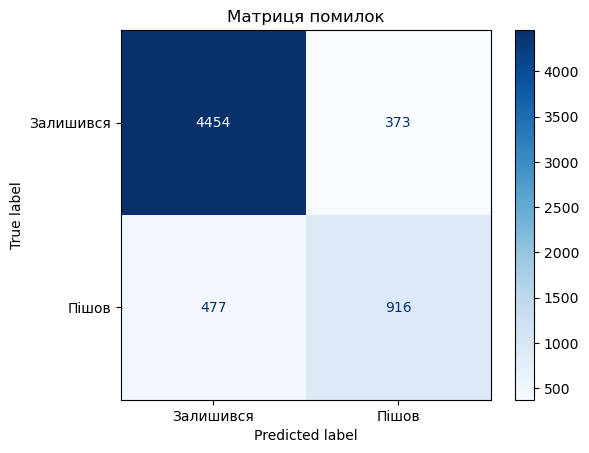

In [37]:
# Перевірка порогу
y_pred_opt = y_pred_proba[:,1]>=0.4
cm = confusion_matrix(y_test, y_pred_opt)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Залишився', 'Пішов'])
disp.plot(cmap='Blues')
plt.title('Матриця помилок')
plt.show()

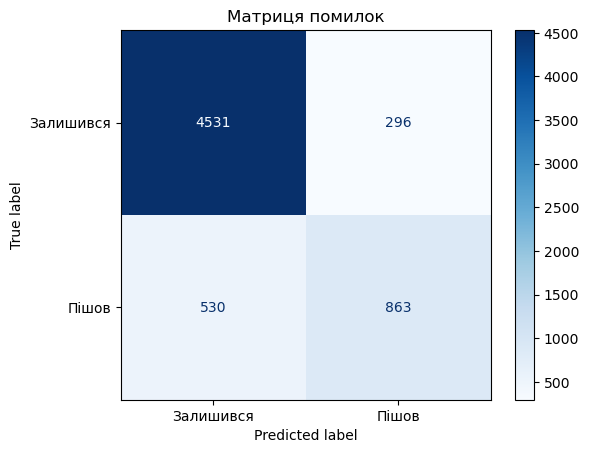

In [41]:
# Спробуємо підібрати вручну кращий поріг
y_pred_opt = y_pred_proba[:,1]>=0.45
cm = confusion_matrix(y_test, y_pred_opt)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Залишився', 'Пішов'])
disp.plot(cmap='Blues')
plt.title('Матриця помилок')
plt.show()

**0.45 є найзбалансованішим порогом.**


---

## Завдання 7 (Опціональне): Покращення моделі та висновки (2 бали)

**Що потрібно зробити:**

На цих же даних навчіть DecisionTreeClassifier та RandomForestClassifier. Яка з трьох моделей дає найкращий результат на тестовому наборі?

Поріг класифікації можна для порівняння якостей моделей використовувати стандартний 0.5, або той, що ви виявили, як оптимальний на попередньому кроці.


In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Навчаємо альтернативні моделі
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_proba)
    })

results_df = pd.DataFrame(results).round(3)
print(results_df)

                 Model  Accuracy  Precision  Recall     F1    AUC
0  Logistic Regression     0.866      0.774   0.569  0.656  0.874
1        Decision Tree     0.903      0.957   0.595  0.734  0.872
2        Random Forest     0.929      0.959   0.714  0.818  0.930


**Найкраще себе показала модель Random Forest.**